In [20]:
!uv add -q -U google-genai

22483.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [21]:
!uv add -q python-dotenv

22489.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [22]:
from dotenv import load_dotenv

load_dotenv()

True

In [23]:
# API 실행

from google import genai

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client()

response = client.models.generate_content(
    model="gemini-3-flash-preview", contents="랭체인과 랭그래프의 관계를 설명해줘."
)
print(response.text)

랭체인(LangChain)과 랭그래프(LangGraph)의 관계는 **'기초 프레임워크와 그 기능을 확장한 전문 라이브러리'**의 관계로 이해할 수 있습니다. 랭그래프는 랭체인 위에서 동작하며, 특히 **복잡한 에이전트(Agent)와 순환(Cycle) 구조**를 만들기 위해 탄생했습니다.

주요 차이점과 관계를 5가지 핵심 포인트로 설명해 드리겠습니다.

---

### 1. 선형 구조(Chain) vs 순환 구조(Graph)
*   **랭체인 (LangChain):** 이름 그대로 '사슬(Chain)'처럼 단계가 순차적으로 이어지는 구조에 최적화되어 있습니다. A단계가 끝나면 B단계로 가는 일방통행 방식(DAG: Directed Acyclic Graph)이 기본입니다.
*   **랭그래프 (LangGraph):** '그래프(Graph)' 구조를 사용하여 **순환(Cycle)**을 허용합니다. 예를 들어, "결과가 만족스럽지 않으면 다시 검색 단계로 돌아가라"와 같은 루프를 구현하기에 매우 적합합니다.

### 2. 상태 관리 (State Management)
*   **랭체인:** 각 단계 사이의 데이터를 전달하는 것이 기본이며, 복잡한 상태를 유지하고 업데이트하는 것이 상대적으로 어렵습니다.
*   **랭그래프:** 전체 워크플로우를 관통하는 **'State(상태)' 객체**가 존재합니다. 여러 에이전트나 단계가 이 상태를 공유하고, 읽고, 수정하며 협업할 수 있습니다. 이는 마치 공유 게시판을 보며 여러 명이 작업하는 것과 같습니다.

### 3. 에이전트에 대한 통제권 (Control)
*   **랭체인:** 기존의 `AgentExecutor`는 편리하지만 내부 로직이 '블랙박스'처럼 작동하여, 개발자가 세밀하게 제어하기 어려운 면이 있었습니다.
*   **랭그래프:** 개발자가 에이전트의 흐름(어느 시점에 어떤 도구를 쓸지, 언제 멈출지 등)을 노드(Node)와 엣지(Edge)로 직접 정의하므로, 훨씬 더 세밀하고 명확한 제어가 가능합니다.

### 

In [24]:
!uv add -U langgraph

22563.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Resolved 47 packages in 178ms                                        
Audited 46 packages in 10ms


In [25]:
!uv add -U langchain

22569.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Resolved 47 packages in 99ms                                         
Audited 46 packages in 5ms


In [26]:
!uv add -U langchain-google-genai

22575.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Resolved 47 packages in 87ms                                         
Audited 46 packages in 0.89ms


### 1. Model 및 Tool 정의


In [27]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
)

In [28]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """MUltiply `a` and `b`.
    
    Args:
        a: First int
        b: Second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.
    
    Args:
        a: First int
        b: Second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.
    
        Args:
            a: First int
            b: Second int
    """
    return a / b

In [29]:
# tools 정의
tools = [multiply, add, divide]

In [30]:
model_with_tools = model.bind_tools(tools)

### 2. State 정의

In [31]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    llm_call: int

### 3. Node 정의

In [ ]:
from langchain.messages import SystemMessage

def llm_call(state) :
    sys_msg = [SystemMessage(content='당신은 사칙연산을 하는 유능한 Agent입니다.')]

    response = model_with_tools.invoke(sys_msg + state['messages'])
    
    return {
        'messages' : [response],
        'llm_call' : state.get('llm_call', 0)
    }

In [64]:
# tool 목록 생성
tools_by_name = { tool.name: tool for tool in tools}

In [65]:
tools_by_name

{'multiply': StructuredTool(name='multiply', description='MUltiply `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x1106f34c0>),
 'add': StructuredTool(name='add', description='Adds `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x1106f3420>),
 'divide': StructuredTool(name='divide', description='Divide `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x1106f3560>)}

In [66]:
# tool_node
from langchain.messages import ToolMessage
def tool_node(state) :

    result = []
    for tool_call in state['messages'][-1].tool_call:
        tool = tools_by_name[tool_call['name']]
        tool_result = tool.invoke(tool_call['args'])

        result.append(ToolMessage(content=tool_result, tool_call_id=tool_call['id']))
    return {'messages': result}

### 4. Graph 생성

In [67]:
from langgraph.graph import StateGraph, START

agent_builder = StateGraph(MessagesState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

agent_builder.add_edge(START, 'llm_call')
agent_builder.add_edge('tool_node', 'llm_call')

In [68]:
from langgraph.graph import END

def should_continue(state : MessagesState) :
    last_message = state['messages'][-1]
    if last_message.tool_calls :
        return 'tool_node'
    else :
        return END

In [69]:
agent_builder.add_conditional_edges(
    'llm_call',
    should_continue,
    [END, 'tool_node']
)

In [70]:
agent = agent_builder.compile()

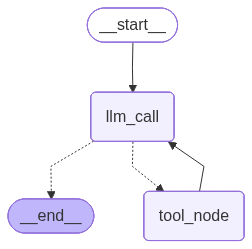

In [71]:
agent

### 실행

In [72]:
from langchain.messages import HumanMessage

messages = [HumanMessage(content="3과 4를 더해줘")]
response = agent.invoke({"messages": messages})

AttributeError: 'AIMessage' object has no attribute 'tool_call'